On a bien aimé ce sujet !

In [1]:
import pandas as pd

df = pd.read_csv('creditcard.csv')


df.drop('Time', inplace=True, axis=1)

In [2]:
from sklearn.ensemble import IsolationForest

true = df[df['Class'] == 0].sample(frac=0.01)
fraude = df[df['Class'] == 1].sample(frac=.5)
import numpy as np


df = pd.concat([true, fraude])

In [3]:
df2 = df.drop('Class', axis=1)
clf = IsolationForest(n_estimators=525, contamination=.08, n_jobs=-1)
clf.fit(df2)
prediction  = clf.predict(df2)

In [6]:
pred = (list(map(lambda x: int(x == -1), prediction)))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
tn, fp, fn, tp = confusion_matrix(np.array(df['Class']), pred).ravel()

accuracy = tp/(tp + fp)
recall = tp/ (tp +fn)
sensibility = tn/(tn + fp)
specificity = (recall)

conf_matrix = pd.DataFrame([[tp,fp],[tn,fn]], columns=['True','False'], index=['Pos','Neg'])

In [7]:
conf_matrix

,True,False
Pos,168,80
Neg,2763,78


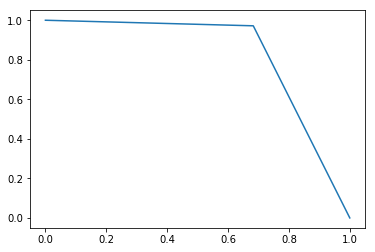

In [11]:
import matplotlib.pyplot as plt

plt.plot([0,specificity,1],[1,sensibility,0])
plt.show()

In [79]:
1-sum(df['Class'])/len(df)

0.92036257688572354

Dans le cadre de la prediction de fraudes, si on detect une fraude qui n'en est pas une (Faux Positif) on peut se permettre ce genre d'erreur. Nous avons fixé le nombre de clients que l'on s'autorise à appeler (ou mail automatique) chaque jour grace au coefficient de contamination (parametre de IsolationForest).
En revanche si l'on ne detecte pas une fraude (Faux négatif) cela est plus grave, la perte d'argent est nette.
Ce qui est important est donc la spécificité (comme dans la détection de maladie)


Comme on peut le voir sur la matrice de confusion, on a autant de Faux positif que de Faux négatif.

On a une spécificité de 0.68, ce qui est correct.

On a affiché la courbe ROC avec un seul point (le seul que l'on puisse avoir), le résultat est satisfaisant


La mise en place d'autres algorithmes peut être intéressante.
Par exemple on peut réappliquer IsolationForest sur les Négatifs.

L'idée est de trouver les positifs qui sont passés entre les mailles du filets.
Ils sont sensés être d'autant plus détectables que les Vrais Positifs sont sortis du dataset par le premier Isolation Forest :

In [55]:
df_sans_index = df.reset_index()

In [56]:
df_pred = pd.concat([df_sans_index, pd.DataFrame(pred, columns=['pred'])],axis=1)

In [57]:
df_pred.drop("index", inplace=True, axis=1)

In [58]:
df_bis = df_pred[df_pred['pred']==0]

In [59]:
df3 = df_bis.drop('Class', axis=1)
clf = IsolationForest(n_estimators=525, contamination=.08, n_jobs=-1)
clf.fit(df3)
prediction_bis  = clf.predict(df3)

In [60]:
pred_bis = (list(map(lambda x: int(x == -1), prediction_bis)))

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
tn, fp, fn, tp = confusion_matrix(np.array(df_bis['Class']), pred_bis).ravel()

accuracy = tp/(tp + fp)
recall = tp/ (tp +fn)
sensibility = tn/(tn + fp)
specificity = (recall)

conf_matrix = pd.DataFrame([[tp,fp],[tn,fn]], columns=['True','False'], index=['Pos','Neg'])

In [61]:
conf_matrix

,True,False
Pos,46,182
Neg,2581,32


Ainsi, on rappelle 182 personnes pour rien, mais on fait tomber les Faux négatifs (ceux qu'on souhaite absolument éviter, à 32

On définit une fonction pour voir à quel point notre idée peut s'itérer

Il est intéressant de voir que certains outliers ne sont quasiment pas détectables avec IsolationForest

In [85]:
def enzo(data=df):
    etape = 0
    pred = [0] * len(data)
    
    long = len(data)
    
    rappel = [0]
    fns = [0]
    while True:
        etape += 1
        data_sans_index = data.reset_index()
        df_pred = pd.concat([data_sans_index, pd.DataFrame(pred, columns=['pred'])],axis=1)
        df_pred.drop("index", inplace=True, axis=1)
        df_bis = df_pred[df_pred['pred']==0]
        data = df_pred[df_pred['pred']==0].drop('pred', axis=1)
        
        _df = df_bis.drop('Class', axis=1)
        clf = IsolationForest(n_estimators=525, contamination=.08, n_jobs=-1)
        clf.fit(_df)
        prediction  = clf.predict(_df)
        pred = (list(map(lambda x: int(x == -1), prediction)))
        from sklearn.metrics import confusion_matrix
        from sklearn.metrics import roc_curve
        tn, fp, fn, tp = confusion_matrix(np.array(df_bis['Class']), pred).ravel()
        
        
        rappel.append(rappel[-1] + tp+fp)
        fns.append(fn)
        
        conf_matrix = pd.DataFrame([[tp,fp],[tn,fn]], columns=['True','False'], index=['Pos','Neg'])
        
        print(conf_matrix)
        print('----------------')
        
        if fn == 0:
            break
            
    plt.plot(rappel,fns)
    plt.show()
    plt.close()
    return [etape, rappel, fns]

     True  False
Pos   169     79
Neg  2764     77
----------------
     True  False
Pos    47    181
Neg  2583     30
----------------
     True  False
Pos     6    203
Neg  2380     24
----------------
     True  False
Pos     7    186
Neg  2194     17
----------------
     True  False
Pos     3    174
Neg  2020     14
----------------
     True  False
Pos     1    162
Neg  1858     13
----------------
     True  False
Pos     1    149
Neg  1709     12
----------------
     True  False
Pos     0    138
Neg  1571     12
----------------
     True  False
Pos     1    126
Neg  1445     11
----------------
     True  False
Pos     1    116
Neg  1329     10
----------------
     True  False
Pos     2    106
Neg  1223      8
----------------
     True  False
Pos     1     98
Neg  1125      7
----------------
     True  False
Pos     3     88
Neg  1037      4
----------------
     True  False
Pos     0     84
Neg   953      4
----------------
     True  False
Pos     0     77
Neg   876     

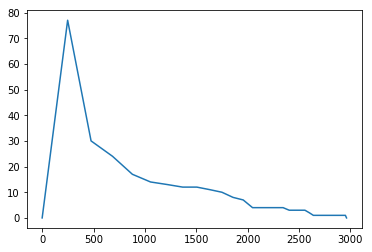

In [86]:
enz = enzo()

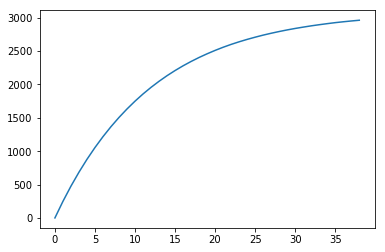

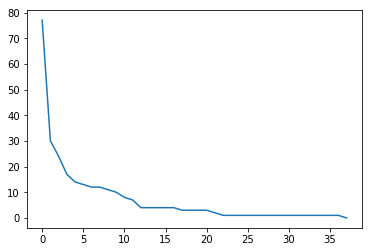

In [91]:
plt.plot(enz[1])
plt.show()
plt.close()
plt.plot(enz[2][1:])
plt.show()

On affiche alors les deux courbes 
Celle du nombre de personnes rappelées et le nombre de faux négatif restant

Les courbes obtenues sont super intéressantes.